In [ ]:
# using python-fmask 

In [2]:
#from fmask import landsatTOA
#landsatTOA.makeTOAReflectance()

GDAL

!gdal_translate

TOA stands for top-of-atmosphere reflectance, which is a measure of how much solar radiation is reflected by the Earth's surface¹. To generate a TOA file with GDAL from a Landsat image, you need to convert the digital numbers (DN) of the image bands to TOA reflectance values using a formula that depends on the sensor type, band number, and acquisition date². You can use the `gdal_translate` tool to apply the formula and create a new raster file with TOA reflectance values for each band. Alternatively, you can use QGIS to calculate TOA reflectance with a solar angle correction for specific bands³.

Here is an example of how to use `gdal_translate` to generate a TOA file for band 4 (red) of a Landsat 8 image acquired on February 3, 2019:

```python
# Define the input and output file paths
input_file = "../Image20190203clip/LC08_L1TP_029047_20190203_20190206_01_T1_B4_clip.TIF"
output_file = "../Output/TOA_B4_20190203.tif"

# Define the sensor type and band number
sensor = "L8"
band = 4

# Define the multiplicative and additive rescaling factors from the metadata file
# These values are specific to each image and band
M = 2.0000E-05
A = -0.100000

# Define the sun elevation angle from the metadata file
# This value is specific to each image
sun_elev = 56.334805

# Calculate the TOA reflectance formula
# This formula is specific to each sensor type and band
if sensor == "L8" and band in [1, 2, 3, 4, 5, 6, 7, 9]:
    # For Landsat 8 OLI bands 1-7 and 9
    toa = "(%s * im + %s) / sin(%s * pi / 180)" % (M, A, sun_elev)
elif sensor == "L8" and band == 8:
    # For Landsat 8 OLI band 8 (panchromatic)
    toa = "(%s * im + %s) / sin(%s * pi / 180)" % (M, A, sun_elev)
elif sensor == "L8" and band in [10, 11]:
    # For Landsat 8 TIRS bands 10 and 11
    toa = "%s * im + %s" % (M, A)
else:
    # For other sensor types and bands
    toa = "im" # No conversion, just keep the original values

# Use gdal_translate to apply the TOA reflectance formula and create a new raster file
gdal_translate -ot Float32 -a_nodata none -of GTiff -b 1 -scale 0 65535 -outsize 100% 100% -r near -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=9 -co TILED=YES -co BIGTIFF=YES --config GDAL_NUM_THREADS ALL_CPUS --config GDAL_CACHEMAX 2048 -co NUM_THREADS=ALL_CPUS --config GDAL_CACHEMAX 2048 -co NUM_THREADS=ALL_CPUS -co COPY_SRC_OVERVIEWS=YES -a_srs EPSG:32629 -co PHOTOMETRIC=MINISBLACK -co ALPHA=NO -co PROFILE=GeoTIFF -co INTERLEAVE=BAND -co GDAL_TIFF_INTERNAL_MASK=YES -co GDAL_TIFF_OVR_BLOCKSIZE=256 -exp %s %s %s
``` % (toa, input_file, output_file)

You can modify the input and output file paths, the sensor type and band number, and the rescaling factors and sun elevation angle according to your specific image and band. You can also change some of the options of the `gdal_translate` tool, such as the output data type, the compression method, the resampling algorithm, and the output size, depending on your needs and preferences. For more information about the `gdal_translate` tool and its options, you can visit [this link](^1^).

I hope this helps you generate a TOA file with GDAL from a Landsat image. If you have any other questions, please let me know! 😊

Quelle: Unterhaltung mit Bing, 30.1.2024
(1) gdal - Calculating Image boundary / footprint of satellite images using .... https://gis.stackexchange.com/questions/61512/calculating-image-boundary-footprint-of-satellite-images-using-open-source-too.
(2) Land Cover Change Analysis with Python and GDAL - Hatari Labs. https://hatarilabs.com/ih-en/land-cover-change-analysis-with-python-and-gdal-tutorial.
(3) Raster data processing with Python and GDAL - notebook.community. https://notebook.community/Automating-GIS-processes/Lesson-7-Automating-Raster-Data-Processing/Python-and-Gdal.
(4) gdal - Calculating Image boundary / footprint of satellite images using .... https://gis.stackexchange.com/questions/61512/calculating-image-boundary-footprint-of-satellite-images-using-open-source-too.
(5) undefined. https://www.lfd.uci.edu/~gohlke/pythonlibs/.

JHJ:

In [1]:
import sys
import os
#import tifffile as tiff
import numpy as np
#import pandas as pd
#import seaborn as sns
import random
import time
from scipy.signal import convolve2d, convolve
#from scipy import ndimage as nd
from multiprocessing.pool import ThreadPool
#from PIL import Image
#from matplotlib import pyplot as plt

#sys.path.insert(0, '../')
#from src.models.Unet import Unet
#from src.models.params import get_params
#from src.utils import get_model_name, extract_collapsed_cls
#from src.models.evaluate_model import calculate_evaluation_criteria, evaluate_test_set

#Image.MAX_IMAGE_PIXELS = 1000000000   
%load_ext autoreload
%autoreload 2

#pd.options.display.max_columns = 9999
#pd.options.mode.chained_assignment = None  # default='warn'

### Run Fmask on the products

The code below assumes that python-fmask (http://pythonfmask.org/en/latest/) is installed in a conda environment named fmask.

In [2]:
fmask_path = "/home/mxh/anaconda3/envs/fmask/bin/"
gdal_path = "/home/mxh/anaconda3/envs/fmask/bin/"
project_path = "/home/mxh/RS-Net/"

In [3]:

def _fmask(n):
    # Run Fmask algorithm on all L1C products
    try:
        print("Processing:", data_path[n]) 
        # setting GTIFF_SRS_SOURCE
        !{gdal_path}gdal_merge.py -separate -of HFA -co COMPRESSED=YES -o {data_path[n]}ref.img {data_path[n]}LC8*_B[1-7,9].TIF
        !{gdal_path}gdal_merge.py -separate -of HFA -co COMPRESSED=YES -o {data_path[n]}thermal.img {data_path[n]}LC8*_B1[0,1].TIF
        
        !{fmask_path}fmask_usgsLandsatMakeAnglesImage.py -m {data_path[n]}*_MTL.txt -t {data_path[n]}ref.img -o {data_path[n]}angles.img                
        !{fmask_path}fmask_usgsLandsatSaturationMask.py -i {data_path[n]}ref.img -m {data_path[n]}*_MTL.txt -o {data_path[n]}saturationmask.img        
        !{fmask_path}fmask_usgsLandsatTOA.py -i {data_path[n]}ref.img -m {data_path[n]}*_MTL.txt -z {data_path[n]}angles.img -o {data_path[n]}toa.img

        !{fmask_path}fmask_usgsLandsatStacked.py -t {data_path[n]}thermal.img -a {data_path[n]}toa.img -m {data_path[n]}*_MTL.txt -z {data_path[n]}angles.img -s {data_path[n]}saturationmask.img -o {output_path + data_path[n][-22:-1]}_fmask.tif --cloudbufferdistance 0 --shadowbufferdistance 0
        
        # Delete all intermediate files
        !rm {data_path[n]}*.img {data_path[n]}*.xml
        
        # Translate to .png file
        !{gdal_path}gdal_translate -of PNG {output_path + data_path[n][-22:-1]}_fmask.tif {output_path + data_path[n][-22:-1]}_fmask.png
        
        # Remove .tif files
        !rm {output_path + data_path[n][-22:-1]}_fmask.tif
        
    except:
        print("FMASK ERROR WITH PRODUCT:", data_path[n])
        pass

In [4]:

# Make a list of the path to all data folders
folders = sorted(os.listdir(project_path + "data/raw/Biome_dataset/"))
folders = [f for f in folders if '.' not in f]  # Filter out .gitignore
data_path = []
for folder in folders:
    products = sorted(os.listdir(project_path + "data/raw/Biome_dataset/" + folder + "/BC/"))
    for product in products:
        data_path.append(project_path + "data/raw/Biome_dataset/" + folder + "/BC/" + product + "/")

# Define output path
output_path = project_path + "data/output/Biome/"

# Do the processing
#pool = ThreadPool(processes=6)
#pool.map(_fmask, (f for f in range(np.size(data_path))))
#pool.close()

# took 81m16s
for f in range(np.size(data_path)):
    _fmask(f)

Processing: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC80420082013220LGN00/
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/mxh/anaconda3/envs/fmask/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
0...10...20...30...40...50...60...70...80...90...100 - done.

Computing Pyramid Layers...
0...10...20...30...40...50...60...70...80...90...100 - done.

Computing Statistics...
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/mxh/anaconda3/envs/fmask/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
0...10...20...30...40...50...60...70...80...90...100 - don

In [ ]:
# Processing: /home/mxh/RS-Net/data/raw/Biome_dataset/Forest/BC/LC80160502014041LGN00/
# 0...10...20...30...40...50...60...70...80...90...100 - done.
# Existing output file has less bands than the input files. You should delete it before. Terminating gdal_merge.

# IndexError: index 1 is out of bounds for axis 0 with size 1
# ERROR 4: /home/mxh/RS-Net/data/output/Biome/LC81720192013331LGN00_fmask.tif: No such file or directory
# rm: cannot remove '/home/mxh/RS-Net/data/output/Biome/LC81720192013331LGN00_fmask.tif': No such file or directory

In [4]:
def _threading_fmask(n):
    try:
        print("Processing:", test_data_path[n]) 
        # setting GTIFF_SRS_SOURCE
        !{gdal_path}gdal_merge.py -separate -of HFA -co COMPRESSED=YES -o {test_data_path[n]}ref.img {test_data_path[n]}LC8*_B[1-7,9].TIF
        !{gdal_path}gdal_merge.py -separate -of HFA -co COMPRESSED=YES -o {test_data_path[n]}thermal.img {test_data_path[n]}LC8*_B1[0,1].TIF
        
        !{fmask_path}fmask_usgsLandsatMakeAnglesImage.py -m {test_data_path[n]}*_MTL.txt -t {test_data_path[n]}ref.img -o {test_data_path[n]}angles.img                
        !{fmask_path}fmask_usgsLandsatSaturationMask.py -i {test_data_path[n]}ref.img -m {test_data_path[n]}*_MTL.txt -o {test_data_path[n]}saturationmask.img        
        !{fmask_path}fmask_usgsLandsatTOA.py -i {test_data_path[n]}ref.img -m {test_data_path[n]}*_MTL.txt -z {test_data_path[n]}angles.img -o {test_data_path[n]}toa.img

        !{fmask_path}fmask_usgsLandsatStacked.py -t {test_data_path[n]}thermal.img -a {test_data_path[n]}toa.img -m {test_data_path[n]}*_MTL.txt -z {test_data_path[n]}angles.img -s {test_data_path[n]}saturationmask.img -o {test_output_path + test_data_path[n][-22:-1]}_fmask.tif --cloudbufferdistance 0 --shadowbufferdistance 0
        
        # Delete all intermediate files
        !rm {test_data_path[n]}*.img {test_data_path[n]}*.xml
        
        # Translate to .png file
        !{gdal_path}gdal_translate -of PNG {test_output_path + test_data_path[n][-22:-1]}_fmask.tif {test_output_path + test_data_path[n][-22:-1]}_fmask.png
        
        # Remove .tif files
        !rm {test_output_path + test_data_path[n][-22:-1]}_fmask.tif
        
    except Exception as e:
        print("FMASK ERROR WITH PRODUCT:", test_data_path[n])
        with open("test_threading_fmask.log.txt", "a") as f:
            f.write(f"Error with file {test_data_path[n]}:\n{e}")
        pass

In [5]:
def _fmask_on_path(file_path):
    try:
        print("Processing:", file_path)
        !{gdal_path}gdal_merge.py -separate -of HFA -co COMPRESSED=YES -o {file_path}ref.img {file_path}LC8*_B[1-7,9].TIF
        !{gdal_path}gdal_merge.py -separate -of HFA -co COMPRESSED=YES -o {file_path}thermal.img {file_path}LC8*_B1[0,1].TIF
        
        !{fmask_path}fmask_usgsLandsatMakeAnglesImage.py -m {file_path}*_MTL.txt -t {file_path}ref.img -o {file_path}angles.img                
        !{fmask_path}fmask_usgsLandsatSaturationMask.py -i {file_path}ref.img -m {file_path}*_MTL.txt -o {file_path}saturationmask.img        
        !{fmask_path}fmask_usgsLandsatTOA.py -i {file_path}ref.img -m {file_path}*_MTL.txt -z {file_path}angles.img -o {file_path}toa.img

        !{fmask_path}fmask_usgsLandsatStacked.py -t {file_path}thermal.img -a {file_path}toa.img -m {file_path}*_MTL.txt -z {file_path}angles.img -s {file_path}saturationmask.img -o {test_output_path + file_path[-22:-1]}_fmask.tif --cloudbufferdistance 0 --shadowbufferdistance 0
        
        # Delete all intermediate files
        !rm {testfile_path}*.img {file_path}*.xml
        
        # Translate to .png file
        !{gdal_path}gdal_translate -of PNG {test_output_path + file_path[-22:-1]}_fmask.tif {test_output_path + file_path[-22:-1]}_fmask.png
        
        # Remove .tif files
        !rm {test_output_path + file_path[-22:-1]}_fmask.tif
        
    except Exception as e:
        print("FMASK ERROR WITH PRODUCT:", file_path)
        with open("test_threading_fmask.log.txt", "a") as f:
            f.write(f"Error with file {file_path}:\n{e}")
        pass

In [3]:
## Define test paths...
test_project_path = project_path
test_output_path = test_project_path + "data/output/Biome/"
test_input_data = "data/raw/Biome_dataset/"
test_processed_data = "data/processed/Biome_TOA/"


In [7]:
from concurrent.futures import ThreadPoolExecutor

# Make a list of the path to all data folders
folders = sorted(os.listdir(test_project_path + test_input_data))
folders = [f for f in folders if '.' not in f]  # Filter out .gitignore
test_data_path = []
for folder in folders:
    products = sorted(os.listdir(test_project_path + test_input_data + folder + "/BC/"))
    for product in products:
        test_data_path.append(test_project_path + test_input_data + folder + "/BC/" + product + "/")

with open("test_threading_fmask.log.txt", "a") as f:
    f.write("\n-------- New Threading Test -----------\n\n")

with ThreadPoolExecutor(max_workers=5) as tpe:
    tpe.map(_threading_fmask, [f for f in range(np.size(test_data_path))])


Processing: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC80420082013220LGN00/
Processing: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC80500092014231LGN00/
Processing: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC80530022014156LGN00/
Processing: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC81330312013202LGN00/
Processing: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC81360302014162LGN00/
00000...10....10....10....10....10...20....20....20....20....20...30....30....30...40...50.30....30...40...50...60....60.40...5040...5040...50..70....70.....60....60....60..80....80.....70..90...100 - done.
..70....70..90...100 - done.
.80....80....80...90...100 - done.
90...100 - done.
90...100 - done.
00...10...20...30...40...50...10...20...30...40...50...60...70...80...90...100 - done.
...60...70...80...90...100 - done.
0/home/mxh/anaconda3/envs/fmask/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptio

In [ ]:
missing_paths = [test_project_path + "data/raw/test_threading/Biome_dataset/Water/BC/LC81040622014066LGN00/"]
missing_paths = [] # remove this line to run _fmask_on_path
for p in missing_paths:
    _fmask_on_path(p)

### Create TOA files

In [4]:
def _create_toa_files(data_path, toa_path):
    print('Processing product: ' + data_path +' into ' + toa_path)
    !{gdal_path}gdal_merge.py -separate -of HFA -co COMPRESSED=YES -o {data_path}ref.img {data_path}LC8*_B[1-7,9].TIF
    !{gdal_path}gdal_merge.py -separate -of HFA -co COMPRESSED=YES -o {data_path}thermal.img {data_path}LC8*_B1[0,1].TIF
    
    !{fmask_path}fmask_usgsLandsatMakeAnglesImage.py -m {data_path}*_MTL.txt -t {data_path}ref.img -o {data_path}angles.img                
    !{fmask_path}fmask_usgsLandsatSaturationMask.py -i {data_path}ref.img -m {data_path}*_MTL.txt -o {data_path}saturationmask.img
    !mkdir -p {toa_path}
    !{fmask_path}fmask_usgsLandsatTOA.py -i {data_path}ref.img -m {data_path}*_MTL.txt -z {data_path}angles.img -o {data_path}toa.img        

    # Translate to .tif file
    !{gdal_path}gdal_translate -of Gtiff {data_path}toa.img {toa_path + data_path[-22:-1]}_toa.TIF

    # Delete all intermediate files
    !rm {data_path}*.img {data_path}*.xml

In [5]:
# Make a list of the path to all data folders
folders = sorted(os.listdir(project_path + test_input_data))
folders = [f for f in folders if '.' not in f]  # Filter out .gitignore
data_paths = []
toa_paths = []


for folder in folders:
    products = sorted(os.listdir(test_project_path + test_input_data + folder + "/BC/"))
    for product in products:
        # print('Processing product: ' + folder +' - ' + product)
        data_paths.append(test_project_path + test_input_data + folder + "/BC/" + product + "/")
        toa_paths.append(test_project_path + test_processed_data + folder + "/BC/" + product + "/")

In [6]:
print(data_paths[0], toa_paths[0])

/home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC80420082013220LGN00/ /home/mxh/RS-Net/data/processed/Biome_TOA/Barren/BC/LC80420082013220LGN00/


In [7]:
import matplotlib.pyplot as plt
from osgeo import gdal

ds = gdal.Open("/home/mxh/RS-Net/data/processed/Biome_TOA/Barren/BC/LC80420082013220LGN00/LC80420082013220LGN00_toa.TIF")
data = ds.ReadAsArray()

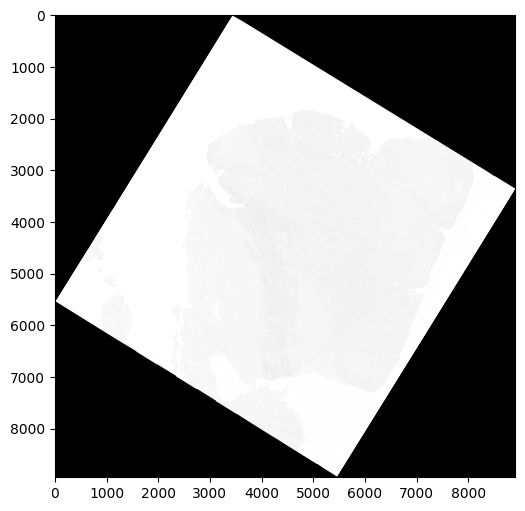

In [15]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(data[5], cmap=plt.cm.Greys)

In [7]:
# try on single file first!:
print(data_paths[0], toa_paths[0])
_create_toa_files(data_paths[0], toa_paths[0])

/home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC80420082013220LGN00/ /home/mxh/RS-Net/data/processed/Biome_TOA/Barren/BC/LC80420082013220LGN00/
Processing product: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC80420082013220LGN00/ into /home/mxh/RS-Net/data/processed/Biome_TOA/Barren/BC/LC80420082013220LGN00/
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/mxh/anaconda3/envs/fmask/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
0...10...20...30...40...50...60...70...80...90...100 - done.

Computing Pyramid Layers...
0...10...20...30...40...50...60...70...80...90...100 - done.

Computing Statistics...
0...10...20...30...40...50...60...70...80...90...100 - done.
/home/mxh/anaconda3/envs/fmask/lib/python3.12/site-packages/osgeo/gdal.

In [8]:
from concurrent.futures import ThreadPoolExecutor
from osgeo import gdal
gdal.UseExceptions()

# not sure if this one ran through error-free!
with ThreadPoolExecutor(max_workers=6) as tpe:
    tpe.map(_create_toa_files, data_paths, toa_paths)

Processing product: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC80420082013220LGN00/ into /home/mxh/RS-Net/data/processed/Biome_TOA/Barren/BC/LC80420082013220LGN00/
Processing product: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC80500092014231LGN00/ into /home/mxh/RS-Net/data/processed/Biome_TOA/Barren/BC/LC80500092014231LGN00/
Processing product: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC80530022014156LGN00/ into /home/mxh/RS-Net/data/processed/Biome_TOA/Barren/BC/LC80530022014156LGN00/
Processing product: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC81330312013202LGN00/ into /home/mxh/RS-Net/data/processed/Biome_TOA/Barren/BC/LC81330312013202LGN00/
Processing product: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC81360302014162LGN00/ into /home/mxh/RS-Net/data/processed/Biome_TOA/Barren/BC/LC81360302014162LGN00/
Processing product: /home/mxh/RS-Net/data/raw/Biome_dataset/Barren/BC/LC81390292014135LGN00/ into /home/mxh/RS-Net/data/processed/Biome